# Logistic Regression 구현
1) 제가 제시한 틀을 사용하여 구현을 할 필요는 없습니다. 원하시는 대로 구현하시면 됩니다.  
2) 단, code copy는 허용하지 않습니다. 코드 주석을 꼭 상세히 달아주세요. 주석이 부족한 경우, 미제출로 간주합니다.

### None 값을 채워주세요!!!!!

In [17]:
import math, random
import random
from functools import partial,reduce
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
"""
data 설명
1) Label: 유료 계정 등록 여부(target)
2) bias: 회귀 모형에서의 상수항을 위한 term (추정 시 포함하지 않아도 ok)
3) experience: 근속연수
4) salary: 연봉

어떤 사용자가 유료 계정을 등록할지(Label == 1)에 대한 예측을 로지스틱 회귀 모형으로 진행합니다.
"""

In [3]:
data = pd.read_csv('assignment_2.csv')

In [4]:
data

Label  bias  experience  salary
0        1     1         0.7   48000
1        0     1         1.9   48000
2        1     1         2.5   60000
3        0     1         4.2   63000
4        0     1         6.0   76000
..     ...   ...         ...     ...
195      0     1         6.5   84000
196      0     1         6.9   73000
197      0     1         5.1   72000
198      1     1         9.1   69000
199      1     1         9.8   79000

[200 rows x 4 columns]

### 0. Gradient Descent

In [5]:
# 지점마다 존재하는 v, diretion 값을 정해진 step_size를 적용해서 최적화
# Theta = Theta - (learning_rate * gradient_of_Coeffients)
def step(v, direction, step_size):
    return [v_i - step_size * direction_i for v_i, direction_i in zip(v, direction)]

In [6]:
def safe(f) :
    """
    f에 대한 예외처리를 위한 함수(f가 infinite일 때)
    """
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f

In [7]:
def minimize_bgd(target_fn, gradient_fn, theta_0, tolerance = 0.00001): # bgd: batch gradient descent
    """
    목적함수를 최소화시키는 theta를 경사 하강법을 사용해서 찾는다.
    """
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    # 시작점 설정
    theta = theta_0
    target_fn = safe(target_fn) # 오류를 처리할 수 있는 target_fn으로 변환, target_fn이 inf 인 경우 제외
    value = target_fn(theta) # 최소화시키려는 값, theta 가 inf 인 경우는 제외
    
    while True:
        gradient = gradient_fn(theta) # gradient값 계산
        next_thetas = [step(theta, gradient, step_size) for step_size in step_sizes] #### 각 step sizes에 따른 theta값의 step() 함수에 대한 결과를 list로 저장
        
        # 함수를 최소화시키는 theta 선택
        obj = next_thetas ## 알맞은 obj, key 값을 채워넣으세요.
        key = target_fn
        next_theta = min(obj, key = key) # target_fn 이 가장 작은 값은 추출
        next_value = target_fn(next_theta)
        
        # tolerance만큼 수렴하면 멈춤
        temp = abs(value - next_value) # temp 채워넣기
        if temp < tolerance:
            return theta
        else: #### 최소값 업데이트 한 뒤 다시 진행
            theta, value = next_theta, next_value
        

In [8]:
def stochastic():
    """
    sgd 구현 (추가적인 부분이니 필수는 아닙니다.)
    random sampling 하는 부분(함수로 따로 구현하셔도 ok) + gd 부분
    """

### 1. 로지스틱 함수
해당 함수는 1/(1+exp[-(ax+b)]로 표현되었음을 기억합시다.

In [9]:
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

In [10]:
import numpy as np

In [11]:
# Softmax(소프트맥스)는 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수

def softmax(x):
    exp_x = np.exp(x) # np.exp() 함수는 밑(base)이 자연상수 e 인 지수함수로 변환
    sum_exp = exp_x.sum() 
    y = exp_x / sum_exp # np.exp(x) 의 총합에 대한 exp_x 을 return, 즉 y 값의 총합은 1이 됨
    return y

### 2. Likelihood 구현
그냥 Likelihood function 대신, log likelihood function을 이용해서 구현하세요.

In [12]:
# 우도란, 어떤 시행의 결과 (Evidence) E 가 주어졌다 할 때, 만일 주어진 가설 H 가 참이라면, 그러한 결과 E 가 나올 정도는 얼마나 되겠느냐 하는 것
# 데이터가 주어졌을 때 어떤 결과가 일어날 가능성을 나타냄

def logistic_log_likelihood_i(x_i, y_i, beta): # 개별 데이터포인트에 대한 likelihood 값
    if y_i == 1: # y_{i} 값이 1(발생) 일 때의 확률 값
        return math.log(logistic(dot(x_i, beta))) 
    else: # y_{i} 값이 0(발생 X) 일 때의 확률 값이므로, 1-(발생확률)
        return math.log(1 - logistic(dot(x_i, beta)))

In [13]:
# [x,y] 집합에 대한 각각의 로그 우도의 합
def logistic_log_likelihood(x, y, beta): # 전체 데이터에 대한 likelihood
    return sum(logistic_log_likelihood_i(x_i, y_i, beta) for x_i, y_i in zip(x, y))

### 3. Gradient for Log Reg
아래 3가지 함수에 대해 해당 함수의 인자와 기능을 자세히 설명하세요.

In [14]:
# 특정 데이터 x_i에 대한 beta_j의 gradient 값 --> 상수 형태의 리턴값 
def logistic_log_partial_ij(x_i, y_i, beta, j):
    return (y_i - logistic(dot(x_i, beta))) * x_i[j]

# x_i(row)에 대한 beta의 gradient 값(column 개수만큼) --> 리스트 형태의 리턴값을 가짐
def logistic_log_gradient_i(x_i, y_i, beta):
    return [logistic_log_partial_ij(x_i, y_i, beta, j) for j, _ in enumerate(beta)]

# 전체 데이터에 대한 beta의 gradient 값 
# --> 이중 리스트를 vector_add 시켜서 beta_j에 대한 gradient값들을 rowSum 해놓은 리스트를 리턴
def logistic_log_gradient(x, y, beta):
    return reduce(vector_add, [logistic_log_gradient_i(x_i, y_i, beta) for x_i, y_i in zip(x,y)])

###설명###

### 4. Model Fitting
위에서 구현한 log likelihood를 이용하여 Model을 Fitting 시켜보세요.  
앞서 우리는 log likelihood를 maximize하는 방향으로 회귀계수를 추정한다고 배웠습니다.  
Gradient Descent는 경사 "하강법"으로 최솟값을 찾는 데에 사용되는 알고리즘입니다.  
따라서 log likelihood를 적절히 변형을 해야 Gradient Descent 코드를 적용할 수 있습니다.  
log likelihood 변형 함수는 assignment2.py에 구현되어있으니, None값만 채워주시면 됩니다.

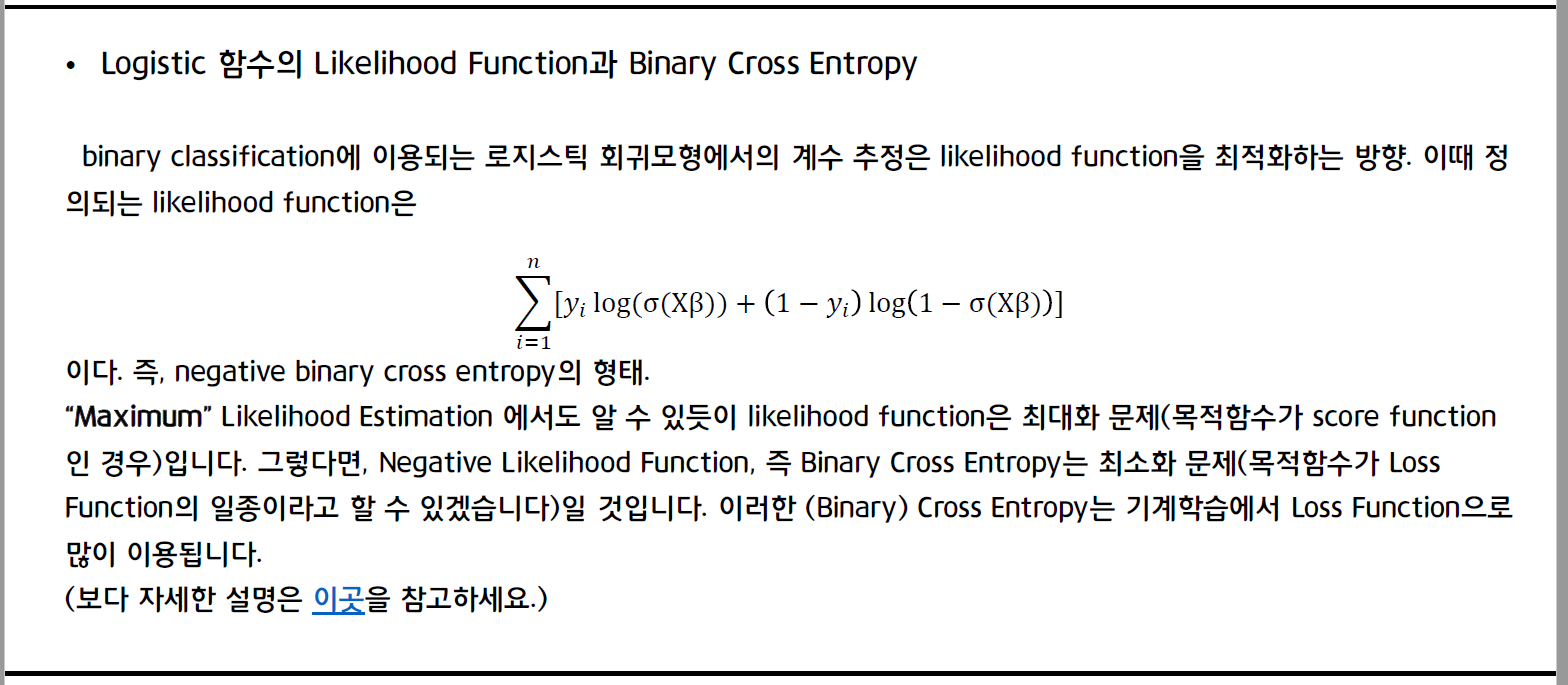  
https://curt-park.github.io/2018-09-19/loss-cross-entropy/

In [27]:
data

Label  bias  experience  salary
0        1     1         0.7   48000
1        0     1         1.9   48000
2        1     1         2.5   60000
3        0     1         4.2   63000
4        0     1         6.0   76000
..     ...   ...         ...     ...
195      0     1         6.5   84000
196      0     1         6.9   73000
197      0     1         5.1   72000
198      1     1         9.1   69000
199      1     1         9.8   79000

[200 rows x 4 columns]

In [23]:
from sklearn.preprocessing import StandardScaler

In [48]:
# train, test 데이터 분할
# train 과 test = 8 : 2
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [49]:
# train, test 로 분할한 뒤 정규화 진행
# 먼저 train
scaler = StandardScaler()
x_train_raw = scaler.fit_transform(train.drop('Label', axis=1))
x_train = pd.DataFrame(x_train_raw, columns = train.columns[:-1])
y_train = train.Label

In [50]:
# 다음 test
x_test_raw = scaler.fit_transform(test.drop('Label', axis=1))
x_test = pd.DataFrame(x_test_raw, columns = test.columns[:-1])
y_test = test.Label

In [51]:
# 각 x,y 값을 매트릭스와 벡터값으로 변환
x_train=x_train.as_matrix()
y_train=y_train.as_matrix()
x_test=x_test.as_matrix()
y_test=y_test.as_matrix()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [52]:
 # partial을 이용해 fn과 gradient_fn 구현
from functools import partial

In [55]:
# 아래에 Model Fitting 진행

fn = partial(logistic_log_likelihood, x_train, y_train)
gradient_fn = partial(logistic_log_gradient, x_train, y_train)

beta_0 = [random.random() for _ in range(3)] # 임의의 시작점

# 경사 하강법으로 최적화
beta_hat = minimize_bgd(fn, gradient_fn, beta_0)

NameError: name 'vector_add' is not defined